# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [3]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [4]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [5]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome')

In [6]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'Krista/blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [7]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# Load files

## mg_network file names

In [74]:
dirpath = Path(settings_dict['save_dir'])


In [75]:
nodefiles = get_cell_filepaths(dirpath)

In [76]:
len(nodefiles)

5472

## df_syn pre or post

In [77]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [78]:
len(df_syn)

18841

# cell types for all files in directory

In [ ]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'

# cell types COMBINE manual and auto for all files in directory

## manual type

In [80]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [81]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [82]:
df_type_auto.dropna(inplace=True)

In [83]:
df_type_auto.head()

,id,cell_type
92,127607174,mg2
94,127672247,mg2
142,129572524,mg1
701,213501262,mg1
725,214440956,mg2


## combine manual and auto df_type

In [84]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [85]:
# for i,r in df_type.iterrows():
#     df_type.loc[i,'fsize'] = nodefiles[str(r['id'])].stat().st_size

# df_type[df_type['type'].isin(['sg2'])].sort_values('fsize').head(20)

In [86]:
df_type.head()

,id,cell_type
0,103366246,uk
1,109461049,fov
2,109502641,mli
3,110418632,uk
4,110611085,fov


# --> df_edges

In [22]:
df_syn

,Unnamed: 0,pre,post,structure,x,y,z
0,0,126618353,303212610,basal dendrite,369840,314688,52260
1,1,126618353,387850816,basal dendrite,369584,313776,52260
2,2,126618353,303212610,basal dendrite,368736,314784,52560
3,3,126618353,394686712,unknown,370112,314832,52620
4,4,126618353,396961287,apical dendrite,369152,313424,52440
...,...,...,...,...,...,...,...
18836,18836,669119245,213605530,basal dendrite,234447,313095,84675
18837,18837,669119245,475781099,basal dendrite,236275,312974,85395
18838,18838,669119245,472361842,basal dendrite,235075,312909,85665
18839,18839,669119245,563840037,basal dendrite,234624,315026,86985


In [87]:
for i,r in df_syn.iterrows():
    
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r)
        continue

In [88]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [89]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [90]:
len(df_edges[df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())

133

In [91]:
len(df_edges[df_edges['pre_type'].isin(['smpl','sgx1','sg1','mg1'])]['pre'].unique())

135

In [46]:
df_edges

,pre,post,pre_type,post_type,weight,annotation
0,130781211,215526370,sg2,lg,32,NaN
1,306461085,301863996,sg2,lg,32,full
2,473631846,305332461,mg2,lg,29,NaN
3,300131090,392814322,mg1,lf,29,NaN
4,390294014,652529320,mg2,lg,27,NaN
...,...,...,...,...,...,...
8291,299530386,308781443,mg1,uk,1,NaN
8292,299530386,308674064,mg1,sgx2,1,NaN
8293,299530386,307558297,mg1,glia,1,NaN
8294,299530386,220616170,mg1,uk,1,NaN


# presynaptic annotation metadata

In [28]:

sheet_name = 'MG_spectrum_presynaptic_input' # replace with your own sheet name
sheet_id = '1c4Wj5gueSrVx-Xcy7mX40HB1n0oLfvcwVmnUr-h8xZM' # replace with your sheet's ID

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [29]:
mdata = pd.read_csv(url)

In [30]:
mdata = mdata.set_index('id')

In [31]:
df_edges['annotation'] = ''
for i,r in df_edges.iterrows():
    try:
        df_edges.loc[i,'annotation']=mdata.loc[r['pre'],'Completeness_annotation']
    except:
        df_edges.loc[i,'annotation']=np.NaN
        continue

# adjust synapse location

In [92]:
df_syn[['x','y','z']] = df_syn[['x','y','z']].div(1000).round(2)

In [93]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x']*1000, r['z']*1000), *popt)
    y_adj = (r['y']) - yoffset/1000
    y_adj_col.append(int(y_adj))

df_syn.loc[:,'y_adj']=y_adj_col

In [94]:
df_syn

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type,y_adj
0,0,126618353,303212610,basal dendrite,369.84,314.69,52.26,mg1,mg2,54
1,1,126618353,387850816,basal dendrite,369.58,313.78,52.26,mg1,mg2,53
2,2,126618353,303212610,basal dendrite,368.74,314.78,52.56,mg1,mg2,54
3,3,126618353,394686712,unknown,370.11,314.83,52.62,mg1,lf,54
4,4,126618353,396961287,apical dendrite,369.15,313.42,52.44,mg1,uk,53
...,...,...,...,...,...,...,...,...,...,...
18836,18836,669119245,213605530,basal dendrite,234.45,313.10,84.68,aff,mg2,55
18837,18837,669119245,475781099,basal dendrite,236.28,312.97,85.40,aff,mg2,55
18838,18838,669119245,472361842,basal dendrite,235.08,312.91,85.66,aff,mg2,55
18839,18839,669119245,563840037,basal dendrite,234.62,315.03,86.98,aff,lf,57


# Completeness of synapses



In [35]:
syn = 'post-synaptic'

In [36]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','n_syn','done','todo','completed']) #'soma-diam',
for c in df_edges['pre'].unique():
    
    if (df_edges[df_edges['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['pre'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': int(cell.cell_data['metadata']['main_seg']['base']),
                'type': cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': int(cell.cell_data['metadata']['main_seg']['base']),
                'type': cell_type[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        cell_df = pd.DataFrame([cell_dict]).dropna(how='all')
        if not cell_df.empty:
            df_progress = pd.concat([df_progress, cell_df], ignore_index=True)

        # df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_3461/3661889730.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_progress = pd.concat([df_progress, cell_df], ignore_index=True)


In [43]:
df_progress[(df_progress['type'].isin(['sg1']))]#.sort_values('id')

,id,type,n_syn,done,todo,completed


# Soma diameter and location

In [95]:
soma_diam = {}
soma_loc = {}
# cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    # cell_type[x] = cell.get_ctype('manual') 

    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        
        xpts = [p[0][0] for p in soma_anno]
        ypts = [p[0][1] for p in soma_anno]
        zpts = [p[0][2] for p in soma_anno]

        if len(soma_anno)==4:
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        elif len(soma_anno)==3:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
        else:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    

In [96]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['soma_x','soma_y','soma_z']

dict_list = [soma_diam]#, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam']#,'cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

df_soma = df_soma.rename_axis('id').reset_index()

df_soma['id'] = df_soma['id'].astype('int')
df_soma = df_soma.replace([np.inf, -np.inf], np.nan)

df_soma[['soma_diam','soma_x','soma_y','soma_z']] = df_soma[['soma_diam','soma_x','soma_y','soma_z']].div(1000).round(2)

In [97]:
y_adj_col = []
for i,r in df_soma.iterrows():
    # print(i,r)
    # break
    yoffset = func((r['soma_x']*1000, r['soma_z']*1000), *popt)
    # print(yoffset)
    y_adj = r['soma_y'] - yoffset/1000
    y_adj_col.append(y_adj)

df_soma.loc[:,'soma_y_adj']=y_adj_col

In [503]:
# df_soma.loc[df_soma['cell_type'].isin(['dml']),'cell_type']='mli'
# df_soma.loc[df_soma['cell_type'].isin(['grc-d']),'cell_type']='grc'
# df_soma.loc[df_soma['cell_type'].isin(['grc-s']),'cell_type']='smpl'

# Cell structures from nodes

In [47]:
h5savepath = Path(dirpath).parent / 'meta_analysis/morphology_cat/'

In [48]:
h5filename_list = ['df_nodes_axon_type1.h5','df_nodes_axon_type2.h5']#,'df_nodes_axon_grc.h5']
suff_ = 'ax_'
df_ax_prepped = pd.DataFrame()
for h5filename in h5filename_list:
  with pd.HDFStore(h5savepath / h5filename) as df_store:
    for i in df_store.keys():
      focal_cell_id = i[1:]
      df_ = df_store[i]
      df_.reset_index(inplace=True)
      df_.rename(columns={'index': 'statistic'}, inplace=True)
      # Step 2: Melt df_bd to combine each column with the 'statistic' column
      df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
      # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
      df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
      df_melted['id'] = int(focal_cell_id)
      df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
      df_ax_prepped = pd.concat([df_ax_prepped, df_reshaped])

h5filename_list = ['df_nodes_bd_type1.h5','df_nodes_bd_type2.h5']#,'df_nodes_bd_grc.h5']
suff_ = 'bd_'
df_bd_prepped = pd.DataFrame()
for h5filename in h5filename_list:
  with pd.HDFStore(h5savepath / h5filename) as df_store:
    for i in df_store.keys():
      focal_cell_id = i[1:]
      df_ = df_store[i]
      df_.reset_index(inplace=True)
      df_.rename(columns={'index': 'statistic'}, inplace=True)
      # Step 2: Melt df_bd to combine each column with the 'statistic' column
      df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
      # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
      df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
      df_melted['id'] = int(focal_cell_id)
      df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
      df_bd_prepped = pd.concat([df_bd_prepped, df_reshaped])

h5filename_list = ['df_nodes_ad_type1.h5','df_nodes_ad_type2.h5'] 
suff_ = 'ad_'
df_ad_prepped = pd.DataFrame()
for h5filename in h5filename_list:
  with pd.HDFStore(h5savepath / h5filename) as df_store:
    for i in df_store.keys():
      focal_cell_id = i[1:]
      df_ = df_store[i]
      df_.reset_index(inplace=True)
      df_.rename(columns={'index': 'statistic'}, inplace=True)
      # Step 2: Melt df_bd to combine each column with the 'statistic' column
      df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
      # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
      df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
      df_melted['id'] = int(focal_cell_id)
      df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
      df_ad_prepped = pd.concat([df_ad_prepped, df_reshaped])

# Merge morphology stats with soma and cell type info

In [49]:
df_ax_prepped = df_ax_prepped.reset_index()
df_ax_prepped.set_index('id',inplace=True)

df_bd_prepped = df_bd_prepped.reset_index()
df_bd_prepped.set_index('id',inplace=True)

df_ad_prepped = df_ad_prepped.reset_index()
df_ad_prepped.set_index('id',inplace=True)

In [98]:
idlist = df_type[df_type['cell_type'].isin(['sg1','sg2','mg1','mg2'])]['id']

data_frames = [df_ax_prepped,df_bd_prepped,df_ad_prepped,df_type[df_type['id'].isin(df_ax_prepped.index)],df_soma[df_soma['id'].isin(df_ax_prepped.index)]] #[df_type[df_type['id'].isin(idlist)],df_soma[df_soma['id'].isin(idlist)]]##,df_ad_prepped

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id'],
                                            how='outer'), data_frames)


In [99]:
df_merged = df_merged[df_merged['cell_type'].isin(['sg1','sg2','mg1','mg2'])]#.head()

In [100]:
df_merged

,id,ax_25%_x,ax_25%_y,ax_25%_z,ax_50%_x,ax_50%_y,ax_50%_z,ax_75%_x,ax_75%_y,ax_75%_z,...,ad_top_z,ad_unique_x,ad_unique_y,ad_unique_z,cell_type,soma_diam,soma_x,soma_y,soma_z,soma_y_adj
0,40448913,145712.0,15759.862193,25200.0,169088.0,19473.778542,34050.0,185632.0,22242.101460,57030.0,...,NaN,NaN,NaN,NaN,mg2,14.02,170.60,252.81,11.50,-4.012452
1,40508404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,mg1,NaN,196.97,257.24,2.28,2.194654
2,40665046,253392.0,6826.321463,5790.0,264832.0,15151.550114,15030.0,272608.0,23014.825083,20370.0,...,NaN,NaN,NaN,NaN,mg2,NaN,269.80,256.83,2.97,5.884696
3,40711545,261568.0,30860.558542,4200.0,270304.0,44836.976133,8700.0,279696.0,54228.773892,16080.0,...,NaN,NaN,NaN,NaN,sg1,7.50,288.88,252.89,6.19,2.262482
4,40729265,261152.0,12607.267920,12750.0,299464.0,16482.863337,24105.0,309620.0,20314.788834,40800.0,...,NaN,NaN,NaN,NaN,mg2,8.78,301.65,253.06,10.08,2.288338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,649497765,129888.0,35544.980297,105090.0,130592.0,35780.953661,105150.0,131888.0,36472.070512,105390.0,...,NaN,NaN,NaN,NaN,sg2,NaN,134.53,298.49,103.84,39.914368
894,649572893,152992.0,24314.433889,80850.0,161824.0,27229.064268,84660.0,169744.0,32305.961058,88050.0,...,NaN,NaN,NaN,NaN,sg2,7.34,164.20,302.87,97.41,44.534689
895,649805291,274152.0,16742.952494,99300.0,275336.0,26156.425952,99810.0,280264.0,35061.609961,101850.0,...,NaN,NaN,NaN,NaN,sg2,5.75,275.34,297.22,97.53,38.817131
896,650501012,55400.0,25716.599267,97875.0,58064.0,30360.592964,99270.0,66248.0,46209.267720,103785.0,...,NaN,NaN,NaN,NaN,sg2,9.45,71.10,308.93,97.82,47.967753


In [53]:
df_type['cell_type'].unique()

array(['uk', 'fov', 'mli', 'pe', 'pf', 'tsd', 'mg1', 'mg2', 'glia', 'sg1',
       'sg2', 'sgx2', 'lg', 'smpl', 'sgx1', 'lf', 'h', 'grc', 'aff', 'UK'],
      dtype=object)

# analyze multidimensional morphology space

In [54]:
syn_colors = {
    'sgx1':'#ffc0cb',#'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#33cc33',
    'smpl':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#00ff00',
    'tsd':'#737373',
    'h':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'uk':'#000000',
    'fov':'#000000'
}

In [101]:
df_morph = deepcopy(df_merged[['id',
                    'ax_std_x','ax_std_z',
                    'bd_std_x','bd_std_z',
                    'ad_count_y','ad_std_y',
                    'soma_diam',#'soma_y_adj',
                               'cell_type']]).set_index(['id'])

In [102]:
df_morph[df_morph[['ad_std_y']].isna().any(axis=1)]#: Returns a boolean Series indicating whether each row contains at least one NaN value.

,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,ad_std_y,soma_diam,cell_type
id,,,,,,,,
568728038,11079.579102,11286.976562,6465.198242,6147.932129,0,NaN,6.78,sg2
644221376,12786.746094,7274.662598,9252.672852,7438.979004,0,NaN,NaN,sg1
645427192,14198.556641,19177.531250,NaN,NaN,0,NaN,NaN,sg1


In [119]:
# df_morph.dropna(inplace=True) # drop nan later with df_clsuter

In [198]:
df_morph.columns

Index(['ax_std_x', 'ax_std_z', 'bd_std_x', 'bd_std_z', 'ad_count_y',
       'ad_std_y', 'soma_diam', 'cell_type'],
      dtype='object')

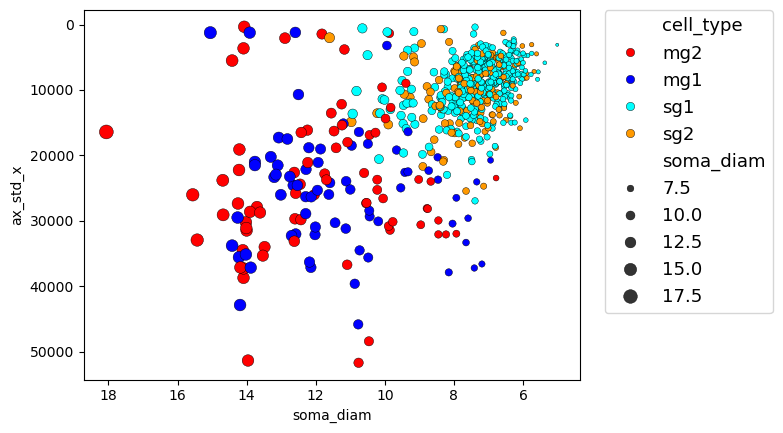

In [104]:
ax=sns.scatterplot(data=df_morph, x='soma_diam', y='ax_std_x', hue='cell_type',
                   size='soma_diam',sizes=(5,100),palette=syn_colors,edgecolors='black')
#,size='soma_diam',sizes = (5,100
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

In [58]:
df_morph[df_morph.index.isin([386409916])]

,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,ad_std_y,soma_diam,cell_type
id,,,,,,,,
386409916,32080.601562,21008.689453,11600.125,18591.048828,23060.0,59992.242924,8.23,mg2


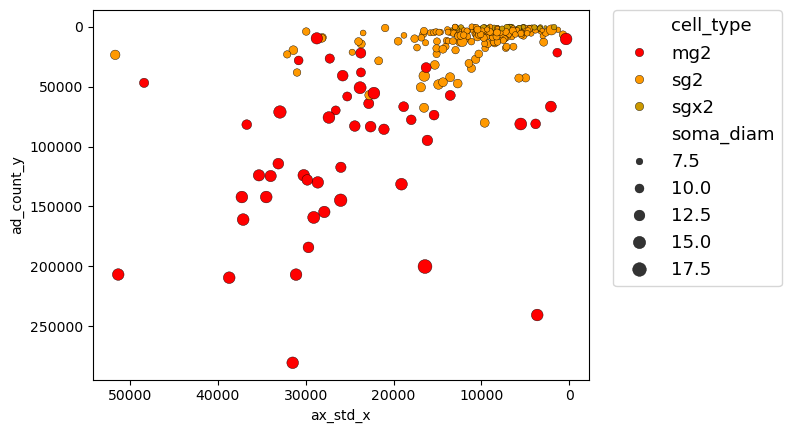

In [981]:
ax=sns.scatterplot(data=df_morph, x='ax_std_x', y='ad_count_y', hue='cell_type',
                   size='soma_diam',sizes=(5,100),palette=syn_colors,edgecolors='black')
#,size='soma_diam',sizes = (5,100
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

## Hierachical clustering

In [59]:
from scipy.cluster.hierarchy import dendrogram

# from sklearn.cluster import AgglomerativeClustering
# from sklearn.datasets import load_iris

from scipy.cluster import hierarchy

import sklearn.metrics as metrics

In [60]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### merge out-of-volume metadata

In [105]:
df = pd.read_csv(dirpath / 'metadata/MG_partial-cat.csv')
df_morph = pd.merge(df_morph, df, on='id', how='left')

In [106]:
df_morph.head()

,id,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,ad_std_y,soma_diam,cell_type,ax,bd,type,ov
0,40448913,30221.712891,23055.279297,35951.195312,25095.257812,124020.0,38562.999621,14.02,mg2,NaN,NaN,NaN,NaN
1,40508404,NaN,NaN,39576.875000,25320.052734,76506.0,51865.965984,NaN,mg1,ov,high,mg1,ax
2,40665046,19252.738281,12088.680664,894.291321,401.306213,124884.0,52918.830237,NaN,mg2,high,ov,mg2,bd
3,40711545,14217.673828,8119.107422,4649.838867,2538.922852,9615.0,56536.305634,7.50,sg1,NaN,NaN,NaN,NaN
4,40729265,28095.630859,21878.687500,10724.816406,4132.157227,8935.0,32361.126619,8.78,mg2,NaN,NaN,NaN,NaN


In [107]:
df_morph.loc[df_morph['cell_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_morph.loc[df_morph['cell_type'].isin(['mg1','mg2']),'class'] = 'mg'

In [ ]:
# df_morph.loc[mask]['class'].value_counts()

### do clustering

In [130]:

mask = df_morph['ov'].isin([np.NaN])
features = ['soma_diam','bd_std_x', 'ax_std_x', 'ax_std_z','bd_std_z','ad_count_y','ad_std_y']# ,'soma_y_adj'

df_cluster = df_morph.loc[mask,features]#df_morph.loc[mask,features]
df_cluster.dropna(axis=0,inplace=True)

In [131]:
df_cluster = df_cluster.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [132]:
df_cluster.head()#.to_numpy(dtype='float32')

,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,ad_std_y
0,2.818605,2.955377,2.014700,1.612280,2.333419,2.894537,0.360589
3,-0.300801,-0.635637,0.165266,-0.603917,-1.082597,-0.269716,1.564685
4,0.311598,0.061308,1.769009,1.437700,-0.841312,-0.288524,-0.054896
5,1.129724,0.299446,0.629565,0.969132,0.230353,0.985835,1.753369
7,0.158498,0.627800,1.262561,1.921100,-0.238816,-0.379741,-0.941690


In [133]:
# distArray = squareform(pdist(df_cluster.to_numpy(dtype='float32'), 'euclidean'))
# squareform(distArray)

In [134]:
Z = hierarchy.linkage(df_cluster, method='ward', metric='euclidean',optimal_ordering=True) #

### visualize

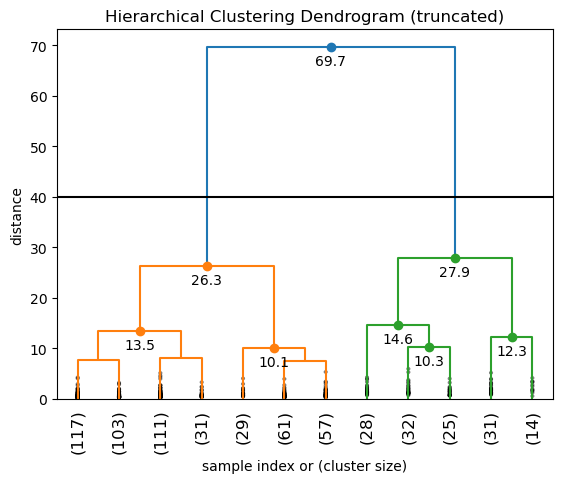

In [121]:
max_d = 40

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [122]:
max_d = 40
clusters = hierarchy.fcluster(Z, max_d, criterion='distance')
df_cluster['label'] = clusters

# df_cluster['label'] =hierarchy.fcluster(Z, 2, criterion='maxclust')

In [123]:
df_cluster['class'] = df_morph.loc[mask]['class']#df_morph.loc[mask]['class']
df_cluster['id'] = df_morph.loc[mask]['id']#df_morph.loc[mask]['id']

In [124]:
df_cluster.groupby(['label','class']).count()

soma_diam  bd_std_x  ax_std_x  ax_std_z  bd_std_z  ad_count_y  \
label class                                                                  
1     mg             1         1         1         1         1           1   
      sg           508       508       508       508       508         508   
2     mg           130       130       130       130       130         130   

             ad_std_y   id  
label class                 
1     mg            1    1  
      sg          508  508  
2     mg          130  130

In [72]:
df_cluster[(df_cluster['label']==2) & (df_cluster['class']=='sg')]['id'].values

array([ 40729265, 217291581, 386178187, 558238428, 558934217, 559381249,
       647917530])

In [125]:
df_cluster[(df_cluster['label']==1) & (df_cluster['class']=='mg')]['id'].values

array([475240034])

### Quality

In [126]:
from scipy.spatial.distance import pdist, squareform

In [135]:
max_d = 40
clusters = hierarchy.fcluster(Z, max_d, criterion='distance')

In [136]:

# Quality1 = metrics.silhouette_score(X=distArray, labels=clusters) # silhouette score
Quality2 = metrics.calinski_harabasz_score(X=df_cluster, labels=clusters) # calinski-harabasz score

In [137]:
Quality2

758.624990776944

## PCA

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [169]:
color_dict = {
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'sg':'pink',
    'mg':'green'
}

### do pca

In [177]:
# df_morph_imputed = df_morph.fillna(df_morph.median())
# df_morph_imputed.dropna(axis=1,inplace=True)
# Select features for PCA
# features = [c for c in df_morph.columns if c not in ['cell_type']]



mask = (df_morph['ov'].isin([np.NaN]))
features = ['soma_diam','bd_std_x', 'ax_std_x', 'ax_std_z','bd_std_z','ad_count_y','ad_std_y']# ,'soma_y_adj'

df_pca = df_morph.loc[mask,features]#df_morph.loc[mask,features]
df_pca.dropna(axis=0,inplace=True)


# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

In [187]:
df_final

,index,id,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,ad_std_y,soma_diam,cell_type,ax,bd,type,ov,class,0
0,0,40448913,30221.712891,23055.279297,35951.195312,25095.257812,124020.0,38562.999621,14.02,mg2,NaN,NaN,NaN,NaN,mg,5.722637
1,1,40508404,NaN,NaN,39508.203125,25352.593750,76506.0,51865.965984,NaN,mg1,ov,high,mg1,ax,mg,-0.656467
2,2,40665046,19252.738281,12088.680664,894.291321,401.306213,124884.0,52918.830237,NaN,mg2,high,ov,mg2,bd,mg,0.839159
3,3,40711545,14217.673828,8119.107422,4649.838867,2538.922852,9615.0,56536.305634,7.50,sg1,NaN,NaN,NaN,NaN,sg,2.088798
4,4,40729265,28095.630859,21878.687500,10724.816406,4132.157227,8935.0,32361.126619,8.78,sg2,NaN,NaN,NaN,NaN,sg,0.936231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,659,648955850,11860.333984,11993.865234,8468.498047,3863.700928,239.0,2640.385108,NaN,sg1,NaN,NaN,NaN,NaN,sg,NaN
660,660,649497765,990.902649,401.477264,3043.539551,7586.205566,6084.0,37988.725595,NaN,sg2,NaN,NaN,NaN,NaN,sg,NaN
661,661,649572893,12009.574219,7293.262207,5188.262207,8897.625000,6971.0,31805.131853,7.34,sg2,NaN,NaN,NaN,NaN,sg,NaN
662,662,649805291,3072.631592,2089.188721,4190.174805,6183.927734,2986.0,21642.207720,5.75,sg2,NaN,NaN,NaN,NaN,sg,NaN


In [181]:
pca = PCA(n_components=len(features))  # You can adjust the number of components as needed
pca_result = pca.fit_transform(df_scaled)

In [182]:
# Convert PCA result to DataFrame
df_pca = pd.DataFrame(pca_result)#, columns=['PC1', 'PC2', 'PC3','PC4','PC5'])

In [186]:
# # Concatenate the PCA result with the original DataFrame
df_final = pd.concat([df_morph.reset_index(), df_pca[[0]]], axis=1) #pd.concat([df_morph.reset_index(drop=True), df_pca[[0,1,2]]], axis=1)

<Axes: xlabel='0'>

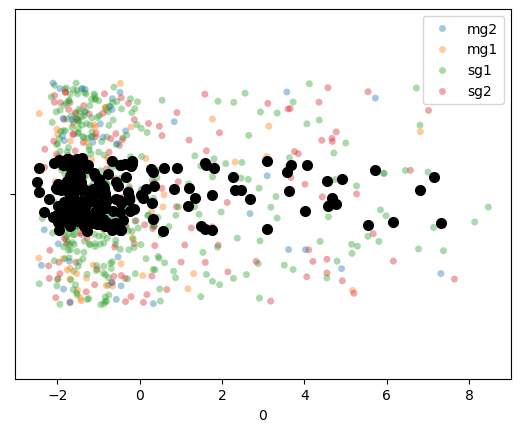

In [176]:
sns.stripplot(data=df_final,x=0,hue='cell_type',jitter = 0.3,alpha = 0.4)
mask = df_final['id'].isin(df_edges['pre'])
sns.stripplot(data=df_final[mask],x=0,color='black',s=8,jitter = 0.1)
# mask = df_final['id'].isin([309774327,394329802])
# sns.stripplot(data=df_final[mask],x=0,color='gray',s=8)
# sns.scatterplot(data=df_final,x=0,y=1,hue='cell_type')

In [987]:
sum(mask)

25

In [154]:
309774327 in df_edges['pre'].values
#309774327

False

In [157]:
df_final[(df_final[0]>6)][['id','cell_type','soma_diam',0]].sort_values(0)

,id,cell_type,soma_diam,0
29,128536704,mg2,12.60,6.212851
60,213605530,mg2,13.70,6.221405
106,301308616,mg2,14.01,6.230985
62,214288055,mg2,18.06,6.632386
143,386117124,mg2,14.18,6.879731
153,387338914,mg2,14.68,7.136115
65,214581797,mg2,14.00,7.659494
97,299249397,mg2,13.96,7.698663


In [439]:
df_final[(df_final[0]>2) & (df_final[0]<4)][['id','cell_type','soma_diam',0]].sort_values(0)

,id,cell_type,soma_diam,0
486,387122660,sg2,8.66,2.052454
422,312018359,grc,5.98,2.106658
3,41733429,sg2,7.14,2.148531
183,216952227,sg2,8.35,2.181106
6,42769344,mg2,11.17,2.199625
727,644205547,mg2,9.97,2.307557
14,47073200,sg2,9.27,2.422012
489,387415866,sg2,8.26,2.496247
59,127607174,sg2,10.08,2.715494
177,215572949,sg2,8.73,2.811026


<Axes: xlabel='0', ylabel='Density'>

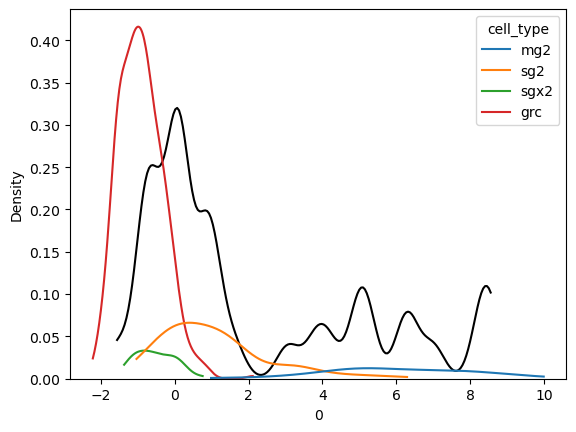

In [523]:
sns.kdeplot(data=df_final[mask],x=0,cut=0,color='black',bw_adjust=0.2)
sns.kdeplot(data=df_final,x=0,cut=0,hue='cell_type',common_norm=True)

# df_input make

with counted input types

In [609]:
'''\Dont use
this does not include cells that don't get input from all of these separate categories of input cells
'''

# maskaff = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['aff']))
# maskdi = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['sg1','smpl','sgx1']))
# masksg = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['sg1','sgx1']))
# masksmpl = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['smpl']))
# df_input = pd.merge(
#         pd.merge(
#             pd.merge(df_edges[maskaff].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'aff'}),
#              df_edges[maskdi].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'di'}),on=['id']),
#         df_edges[masksg].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'sg'}),on=['id']),
#     df_edges[masksmpl].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'smpl'}),on=['id'])

In [1046]:
# Example groupby operation
grouped_df = df_edges.groupby(['pre', 'post_type'])['weight'].sum().unstack()

# Reset index to make 'pre' a column again
grouped_df = grouped_df.reset_index()

# Filter to include only the desired 'post_type' columns
grouped_df = grouped_df[['pre','aff', 'smpl', 'sgx1', 'sg1', 'mg1']].fillna(0)

# Drop duplicates in the original dataframe to keep only the relevant 'pre', 'pre_type', and 'annotation' columns
pre_info = df_edges[['pre', 'pre_type', 'annotation']].drop_duplicates()

# Merge the groupby result with the pre_info dataframe
sum_edge_df = pd.merge(grouped_df, pre_info, on='pre', how='left')

df_input = sum_edge_df[sum_edge_df['pre_type'].isin(['grc','sgx2','sg2','mg2'])].rename(columns = {'pre':'id'})

In [1047]:
df_input['di'] = df_input[['smpl','sgx1','sg1']].sum(axis=1)
df_input['sg'] = df_input[['sgx1','sg1']].sum(axis=1)

In [1048]:
df_input = pd.merge(df_soma,df_input,on='id')

In [1049]:
df_input = pd.merge(df_input,df_progress,on='id')
df_input = pd.merge(df_input,df_type,on='id')

In [1050]:
df_input = df_input.set_index('id')#.head()

In [1019]:
df_input.index

Index([126649726, 213605530, 214581797, 215492896, 216129202, 218095913,
       221746236, 222597526, 223881844, 226019332, 227254070, 228321391,
       228366816, 299404889, 300226567, 306461085, 309774327, 313068329,
       385434515, 386392158, 386426114, 387850816, 389891998, 393433572,
       394329802, 394423863, 394470350, 395461156, 395507584, 400210172,
       403522169, 473491444, 477962738, 481412554, 482680782, 483610898,
       483689146,  50786130, 647514445],
      dtype='object', name='id')

## add pc0 data

In [1051]:
for i,r in df_input.iterrows():
    try:
        df_input.loc[r.name,'pc0']=df_final.set_index('id').loc[r.name,0]
    except:
        df_input.loc[r.name,'pc0']=np.NaN
        continue

df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,annotation,di,sg,type,n_syn,done,todo,completed,cell_type,pc0
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,partial,90.0,70.0,mg2,161,161,0,1.000000,mg2,4.278643
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,partial,76.0,64.0,mg2,141,141,0,1.000000,mg2,3.958438
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,full,246.0,206.0,mg2,582,581,1,0.998282,mg2,4.068856
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,full,103.0,77.0,mg2,225,204,21,0.906667,mg2,2.543373
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,full,27.0,22.0,mg2,86,64,22,0.744186,mg2,2.682572


In [1021]:
for i,r in df_input.iterrows():
    try:
        df_input.loc[r.name,'ad_count_y']=df_final.set_index('id').loc[r.name,'ad_count_y']
    except:
        df_input.loc[r.name,'ad_count_y']=np.NaN
        continue

df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,90.0,70.0,mg2,161,161,0,1.000000,mg2,7.589232,240695.0
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,76.0,64.0,mg2,141,141,0,1.000000,mg2,8.342251,154640.0
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,246.0,206.0,mg2,582,581,1,0.998282,mg2,11.191788,280583.0
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,103.0,77.0,mg2,225,204,21,0.906667,mg2,5.059989,28112.0
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,27.0,22.0,mg2,86,64,22,0.744186,mg2,5.042490,38128.0


In [762]:
df_input[df_input['type'].isin(['grc'])]

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,pre_type,annotation,type,n_syn,done,todo,completed,cell_type,pc0
id,,,,,,,,,,,,,,,,,,,
222597526,6.08,218.74,315.98,39.45,61.372374,22.0,7.0,9.0,0.0,0.0,grc,partial,grc,98,98,0,1.000000,grc,-0.520477
223881844,5.93,274.24,320.93,35.19,68.048110,25.0,1.0,1.0,1.0,0.0,grc,full,grc,96,96,0,1.000000,grc,-0.707274
226019332,5.59,208.98,334.21,36.81,79.334850,34.0,0.0,0.0,0.0,0.0,grc,full,grc,86,86,0,1.000000,grc,-0.486878
227254070,5.68,252.66,337.82,35.64,84.610441,11.0,0.0,0.0,0.0,0.0,grc,full,grc,42,24,18,0.571429,grc,-1.562110
228321391,5.14,215.26,347.04,33.75,92.653900,1.0,0.0,0.0,0.0,0.0,grc,full,grc,11,11,0,1.000000,grc,-1.402314
228366816,6.80,232.78,349.86,29.90,96.483471,10.0,0.0,0.0,0.0,0.0,grc,full,grc,96,51,45,0.531250,grc,-0.374506
313068329,6.88,220.96,341.68,52.53,86.165277,6.0,0.0,0.0,0.0,0.0,grc,partial,grc,43,24,19,0.558140,grc,0.138246
395461156,6.58,200.38,322.40,60.73,65.606753,19.0,7.0,1.0,0.0,0.0,grc,partial,grc,79,77,2,0.974684,grc,0.155559
400210172,5.74,276.59,349.24,56.91,93.924644,3.0,0.0,0.0,0.0,0.0,grc,full,grc,28,28,0,1.000000,grc,-0.727718


In [1022]:
mask = (df_input['annotation']=='full') #& (df_input['completed']<0.85)
df_input[mask].sort_values('pc0')#.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
227254070,5.68,252.66,337.82,35.64,84.610441,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,42,24,18,0.571429,grc,-1.551817,0.0
228321391,5.14,215.26,347.04,33.75,92.653900,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,11,11,0,1.000000,grc,-1.417341,0.0
483689146,6.52,228.02,332.87,78.22,75.750904,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,122,60,62,0.491803,grc,-0.947175,0.0
394329802,5.90,206.58,313.57,55.72,57.326182,4.0,6.0,4.0,21.0,0.0,...,31.0,25.0,sgx2,51,51,0,1.000000,sgx2,-0.842668,1280.0
400210172,5.74,276.59,349.24,56.91,93.924644,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,28,28,0,1.000000,grc,-0.778733,0.0
223881844,5.93,274.24,320.93,35.19,68.048110,25.0,1.0,1.0,1.0,0.0,...,3.0,2.0,grc,96,96,0,1.000000,grc,-0.769745,0.0
226019332,5.59,208.98,334.21,36.81,79.334850,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,86,86,0,1.000000,grc,-0.560746,0.0
228366816,6.80,232.78,349.86,29.90,96.483471,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,96,51,45,0.531250,grc,-0.477878,0.0
403522169,6.41,218.95,365.14,60.33,108.975384,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,33,11,22,0.333333,grc,-0.428073,0.0


In [764]:
len(df_input)

39

In [ ]:
[394470350, 481412554, 389891998, 482680782, 483689146, 223881844,
       309774327, 214581797,  50786130, 393433572, 226019332, 306461085,
       647514445, 216129202, 218095913, 221746236, 300226567, 215492896,
       387850816, 227254070, 394329802, 228366816, 403522169, 400210172,
       228321391]

# visualize

In [40]:
syn_colors = {
    'sgx1':'#ffc0cb',#'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc':'#33cc33',
    'smpl':'#e6e600',
    'dml':'#cccccc',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#00ff00',
    'tsd':'#737373',
    'h':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'uk':'#000000',
    'fov':'#000000'
}

In [924]:
df_soma = pd.merge(df_soma,df_type,on='id')

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

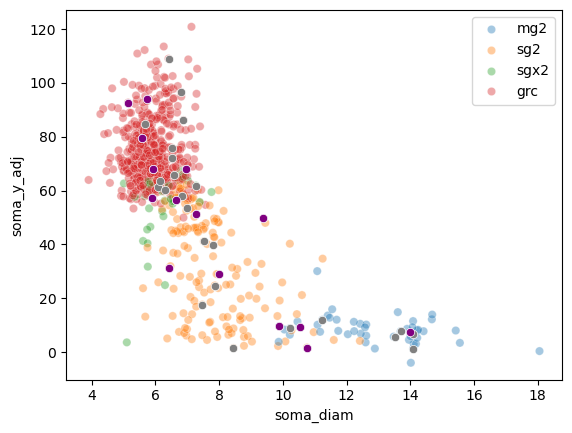

In [925]:
mask = df_soma['cell_type'].isin(['grc','sgx2','sg2','mg2'])
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',hue='cell_type',alpha = 0.4)

mask = df_soma['id'].isin(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color = 'gray')

mask = df_soma['id'].isin(df_input[(df_input['annotation']=='full') & (df_input['completed']>0.85)].index.unique())
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color='purple')#,{'marker':'X'})

In [205]:
# list(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

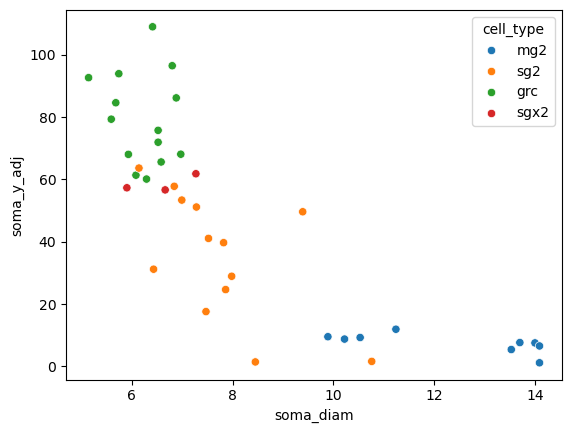

In [884]:
mask = df_soma['id'].isin(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',hue='cell_type')

In [969]:
# pd.merge(df_final.reset_index(),df_morph.reset_index(),on='id')
df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,90.0,70.0,mg2,161,161,0,1.000000,mg2,4.131090,4.131090
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,76.0,64.0,mg2,141,141,0,1.000000,mg2,4.734261,4.734261
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,246.0,206.0,mg2,582,581,1,0.998282,mg2,6.678509,6.678509
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,103.0,77.0,mg2,225,204,21,0.906667,mg2,2.461180,2.461180
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,27.0,22.0,mg2,86,64,22,0.744186,mg2,2.453538,2.453538


Text(0, 0.5, 'soma diameter')

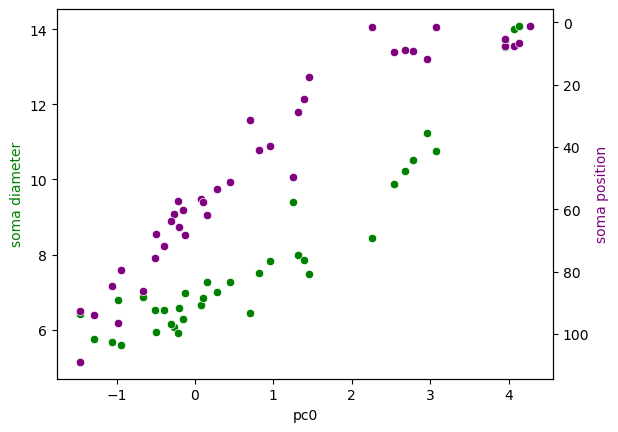

In [1052]:
fig, ax1 = plt.subplots()#figsize=(15,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(ax = ax1, data=df_input,y='soma_diam',x='pc0',color = 'green')

sns.scatterplot(ax = ax2, data=df_input,y='soma_y_adj',x='pc0',color = 'purple')
ax2.invert_yaxis()
ax2.set_ylabel('soma position',color='purple')

# sns.scatterplot(ax = ax2, data=df_input,y='ad_count_y',x='pc0',color = 'purple')
# ax2.set_ylabel('apical nodes',color='purple')


ax1.set_ylabel('soma diameter',color='green')


Text(0, 0.5, 'disinhibition input')

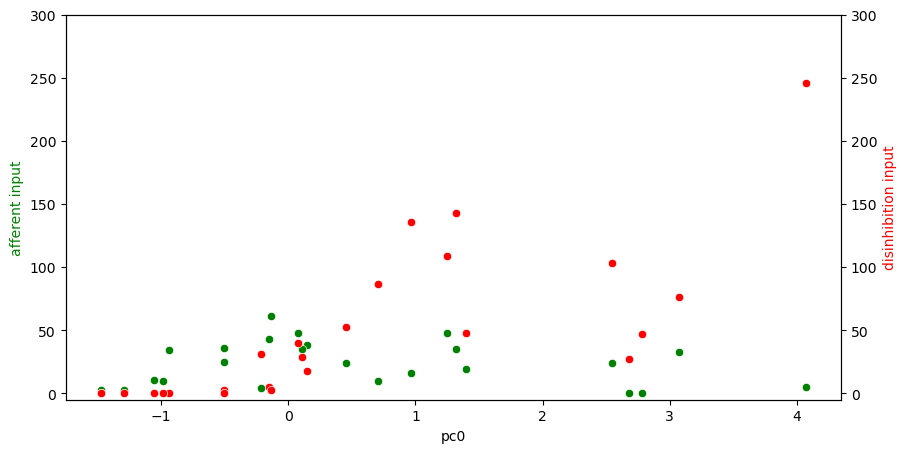

In [1053]:
mask = df_input['annotation']=='full'

fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=df_input[mask],x='pc0',y='aff',ax = ax1, color='green')
sns.scatterplot(data=df_input[mask],x='pc0',y='di',ax = ax2,color='red')
# ax.set_ylim(0,2)
ax1.set_ylim(-5,300);ax1.set_ylabel('afferent input',color='green')
ax2.set_ylim(-5,300);ax2.set_ylabel('disinhibition input',color='red')

Text(0, 0.5, 'aff / disinhib')

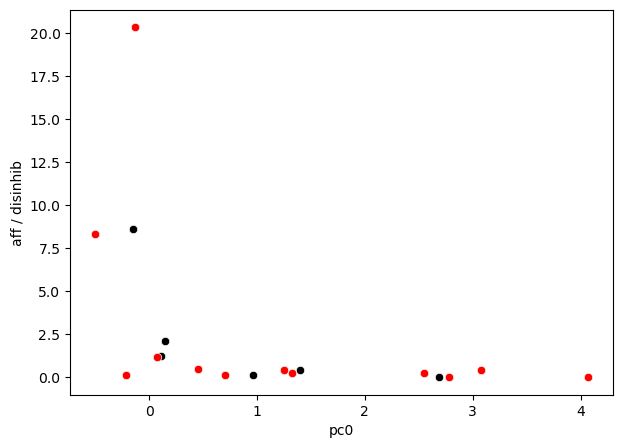

In [1054]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots
mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color = 'black')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color='red')

# mask = df_input['annotation']=='partial'
# sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color='gray')

# ax1.set_ylim(-1,5)
ax1.set_ylabel('aff / disinhib')

<Axes: xlabel='pc0', ylabel='aff'>

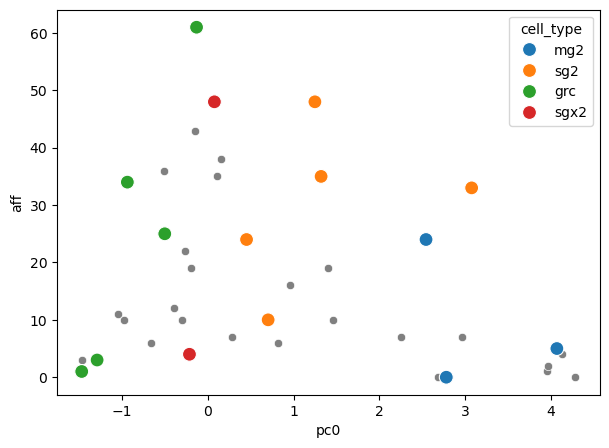

In [1055]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation'].isin(['full','partial'])#df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='sg'>

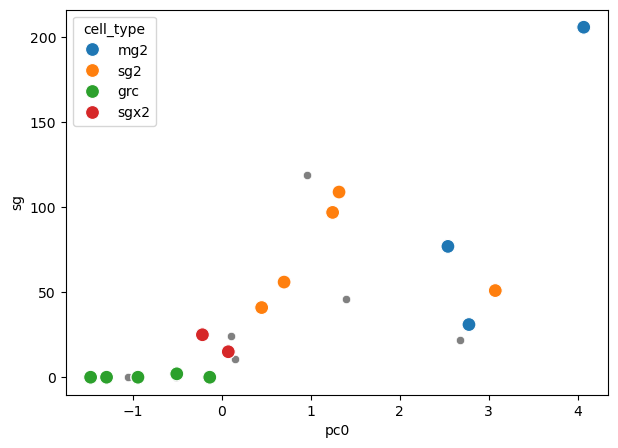

In [1056]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['sg'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['sg'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='smpl'>

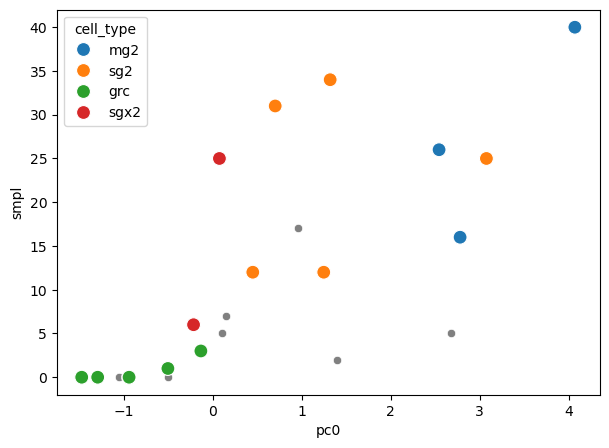

In [1057]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['smpl'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['smpl'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='di'>

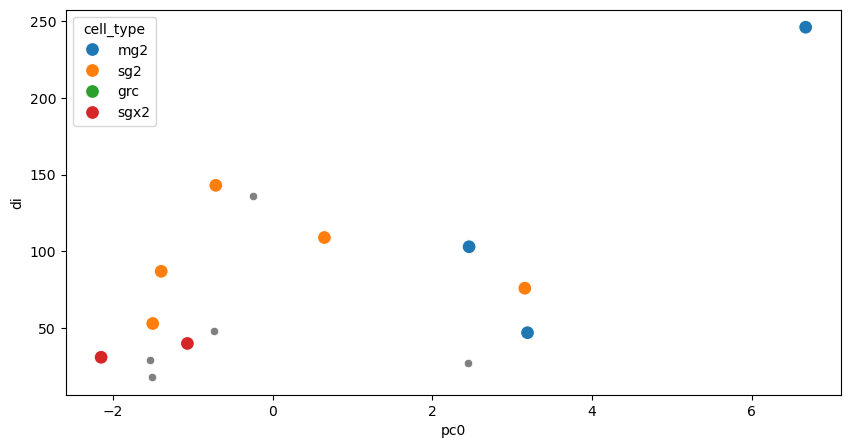

In [932]:
fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['di'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['di'],hue='cell_type',s=100)

# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

## regardless of morphology

, across these type2 cells, how are aff and disinhibition input related

<Axes: xlabel='aff', ylabel='di'>

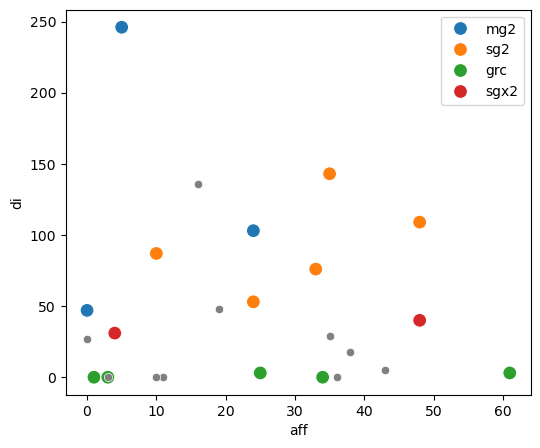

In [1031]:
fig, ax1 = plt.subplots(figsize=(6,5)) # initializes figure and plots

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='aff',y='di',hue='cell_type',s=100)

mask = (df_input['annotation']=='full') & (df_input['completed']<0.85)
sns.scatterplot(data=df_input[mask],x='aff',y='di',color='gray')
# ax1.set_ylim(0,5)
# ax1.set_ylabel('aff / disinhib')

Text(0, 0.5, 'smpl')

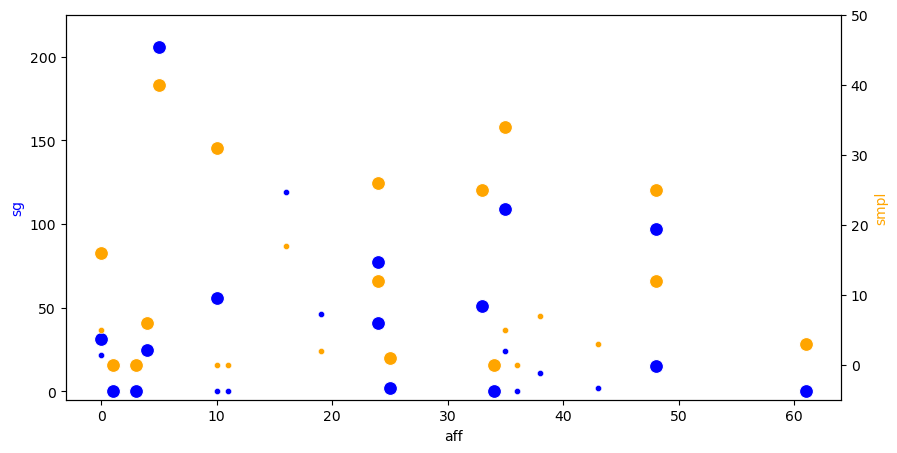

In [1063]:
# fig, ax1 = plt.subplots(figsize=(8,5)) # initializes figure and plots

fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

mask = (df_input['annotation']=='full') #& (df_input['completed']>0.85)
# sns.scatterplot(data=df_input[mask],x='aff',y='sg1',color='purple',s=100)
sns.scatterplot(ax = ax1, data=df_input[mask],x='aff',y='sg',color='blue',s=20)
sns.scatterplot(ax = ax2, data=df_input[mask],x='aff',y='smpl',color='orange',s=20)

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
# sns.scatterplot(data=df_input[mask],x='aff',y='sg1',color='purple',s=100)
sns.scatterplot(ax = ax1, data=df_input[mask],x='aff',y='sg',color='blue',s=100)
sns.scatterplot(ax = ax2, data=df_input[mask],x='aff',y='smpl',color='orange',s=100)

ax1.set_ylim(-5,225); ax1.set_ylabel('sg',color='blue')
ax2.set_ylim(-5,50); ax2.set_ylabel('smpl',color='orange')

# # ax1.set_ylim(0,5)

# ax1.set_ylabel('sg (blue); smpl (orange)')

# fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
# ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

# sns.scatterplot(data=df_input[mask],x='pc0',y='aff',ax = ax1, color='green')
# sns.scatterplot(data=df_input[mask],x='pc0',y='di',ax = ax2,color='red')
# # ax.set_ylim(0,2)
# ax1.set_ylim(-5,300);ax1.set_ylabel('afferent input',color='green')
# ax2.set_ylim(-5,300);ax2.set_ylabel('disinhibition input',color='red')

<Axes: xlabel='smpl', ylabel='sg'>

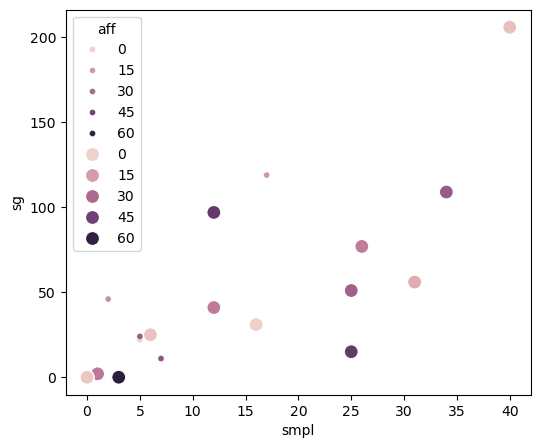

In [1036]:
fig, ax1 = plt.subplots(figsize=(6,5)) # initializes figure and plots

mask = (df_input['annotation']=='full') #& (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='smpl',y='sg',color='blue',hue='aff',s=20)

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='smpl',y='sg',color='blue',hue='aff',s=100)

In [114]:
df_syn[df_syn['pre_type'].isin(['sgx2'])]['pre'].unique()

array([394470350])

In [113]:
df_syn[df_syn['pre_type'].isin(['sg2'])]['pre'].unique()

array([218095913, 306461085, 385434515, 389891998, 393433572, 394423863,
       395507584, 473491444, 477962738,  50786130, 647514445])

In [247]:
df_syn[df_syn['pre_type'].isin(['grc'])]['pre'].unique()

array([222597526, 223881844, 226019332, 227254070, 228321391, 228366816,
       313068329, 395461156, 400210172, 403522169, 481412554, 482680782,
       483610898, 483689146])

## synapse annotations plotted in space

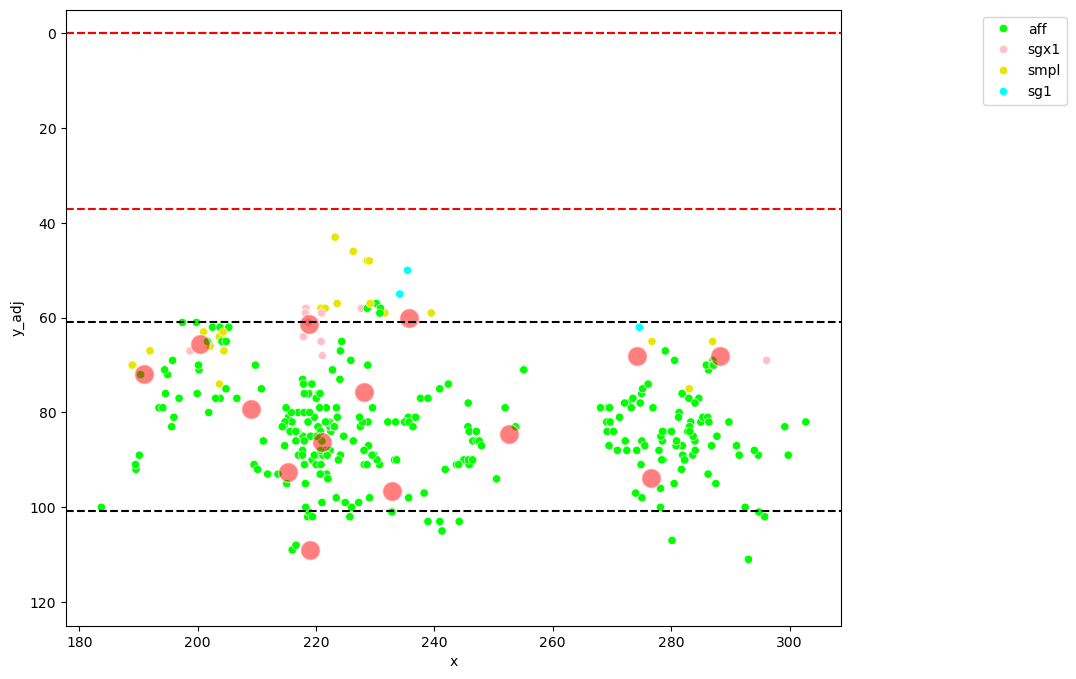

In [1071]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['grc'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
# ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

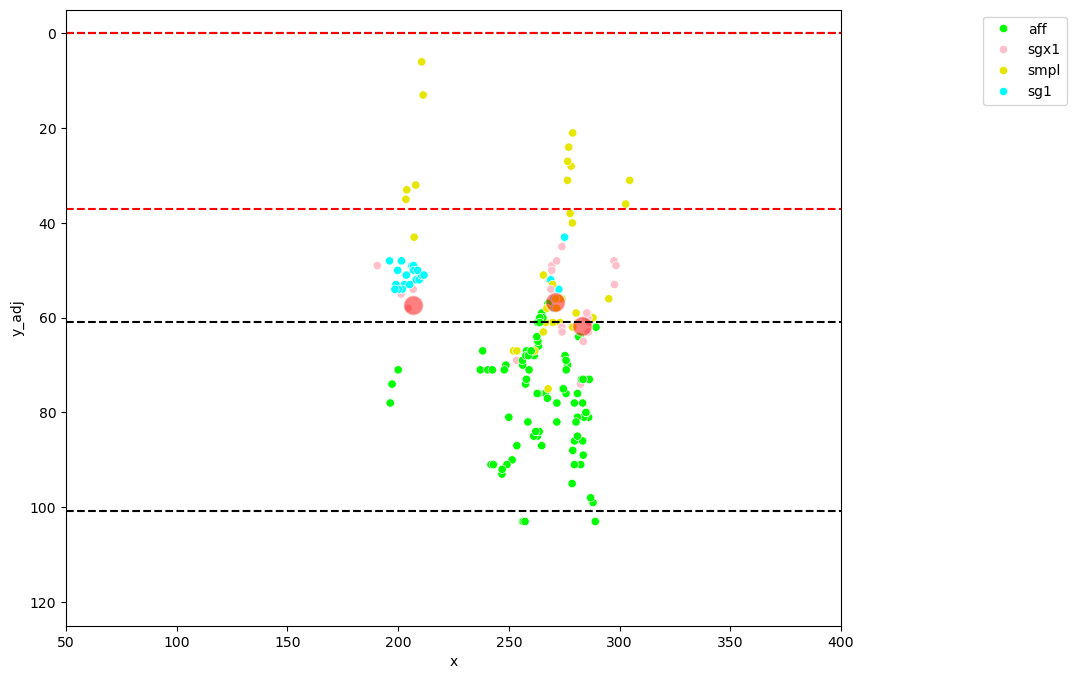

In [1072]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['sgx2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

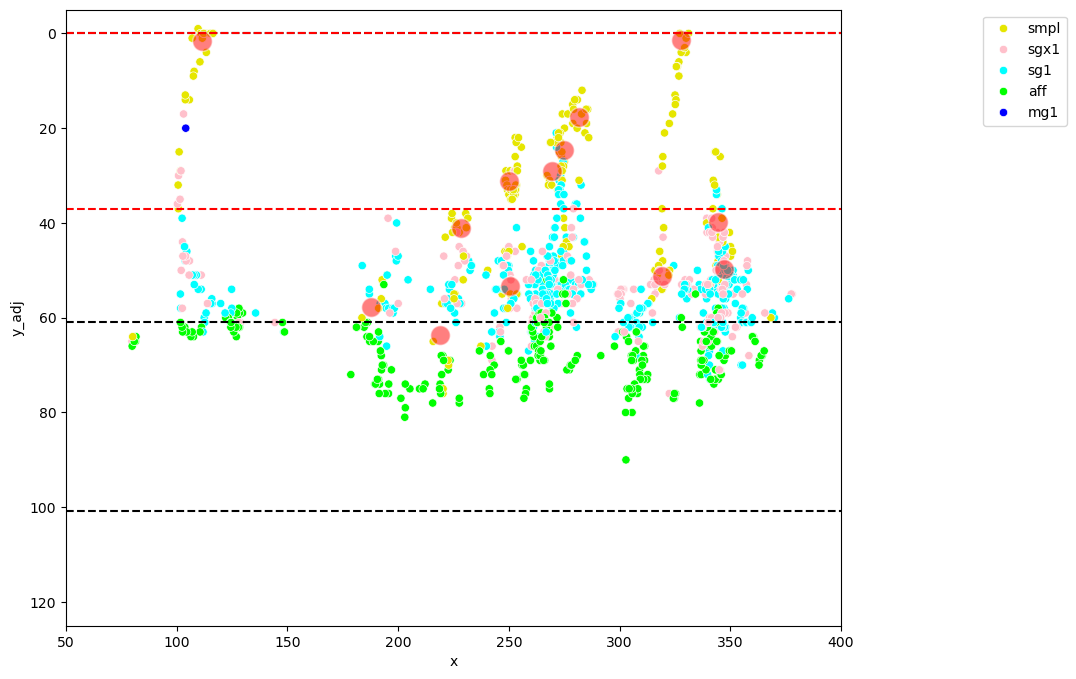

In [1074]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['sg2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

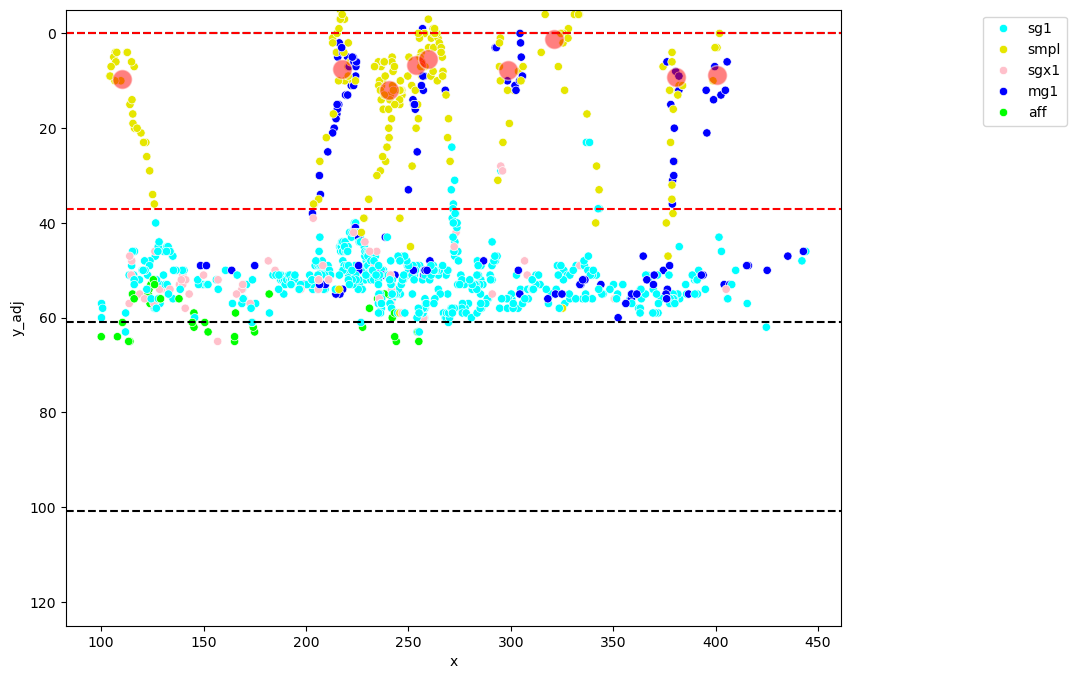

In [1075]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['mg2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
# ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

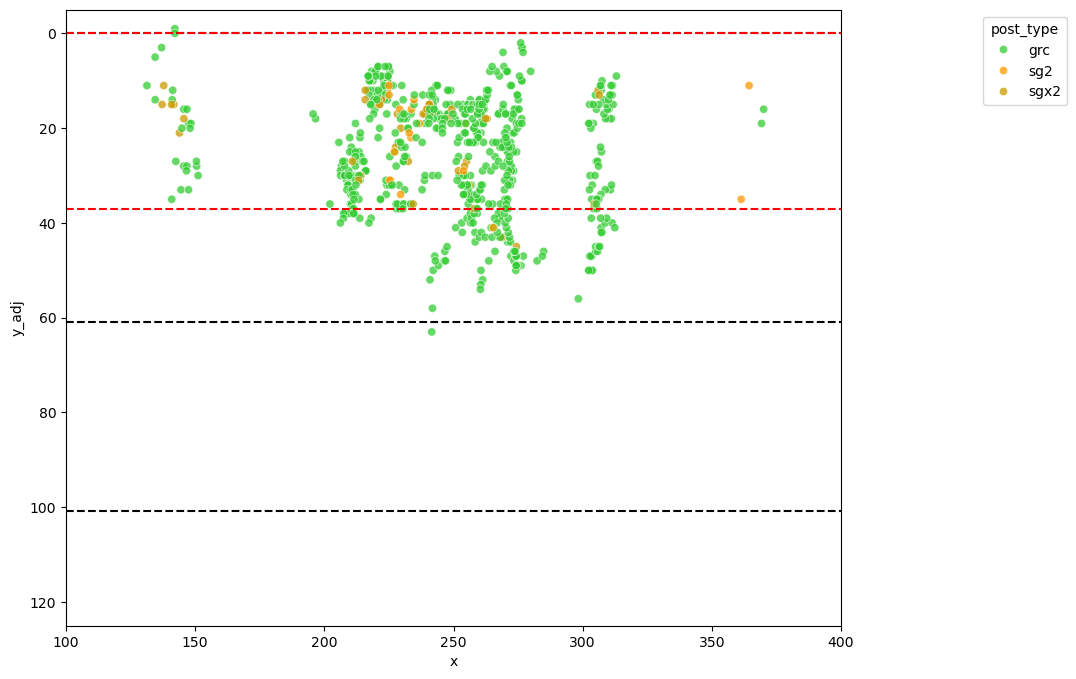

In [131]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['sg1']) & df_syn['post_type'].isin(['mg2','sg2','sgx2','grc'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

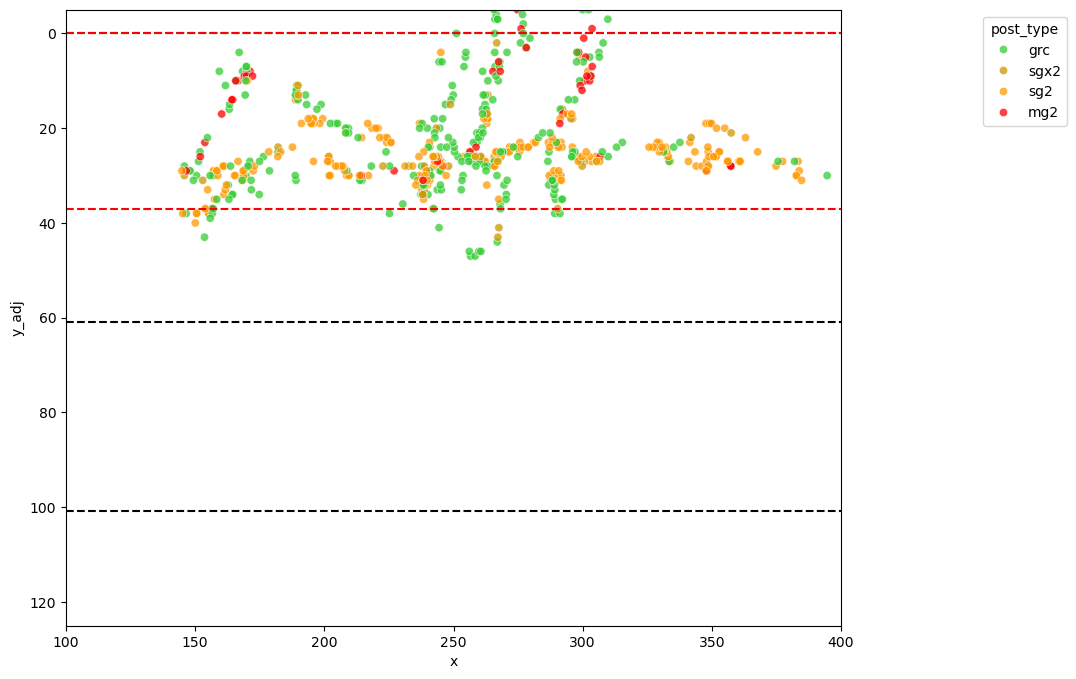

In [130]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['mg1']) & df_syn['post_type'].isin(['mg2','sg2','sgx2','grc'])#'smpl','aff'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

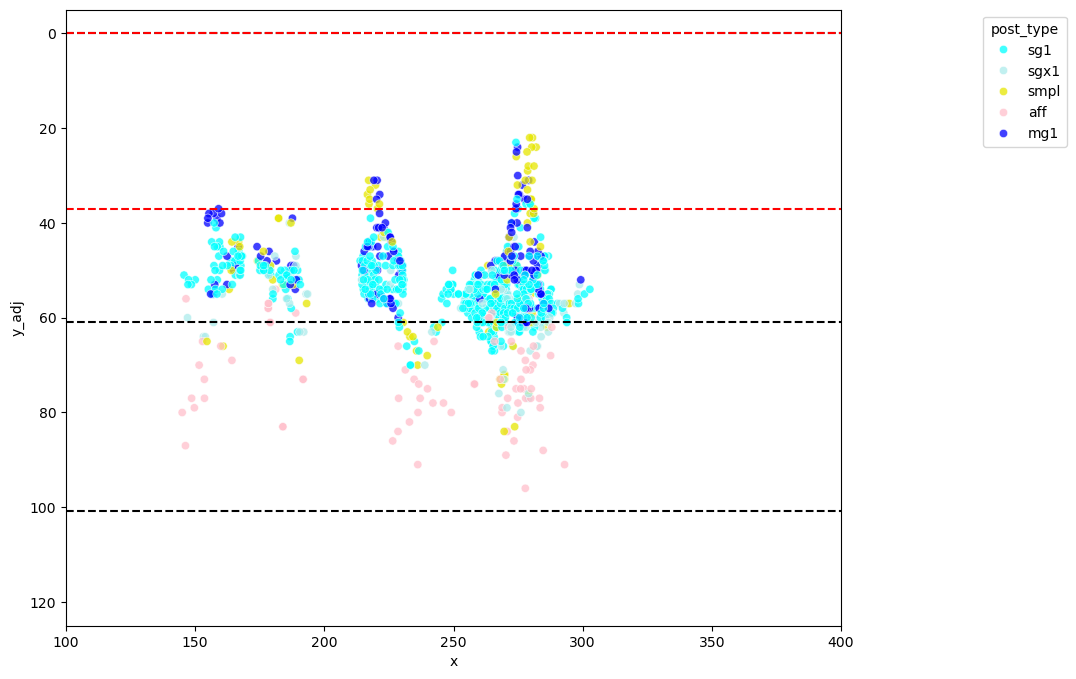

In [113]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['lf']) & df_syn['post_type'].isin(['mg1','sg1','sgx1','smpl','aff'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

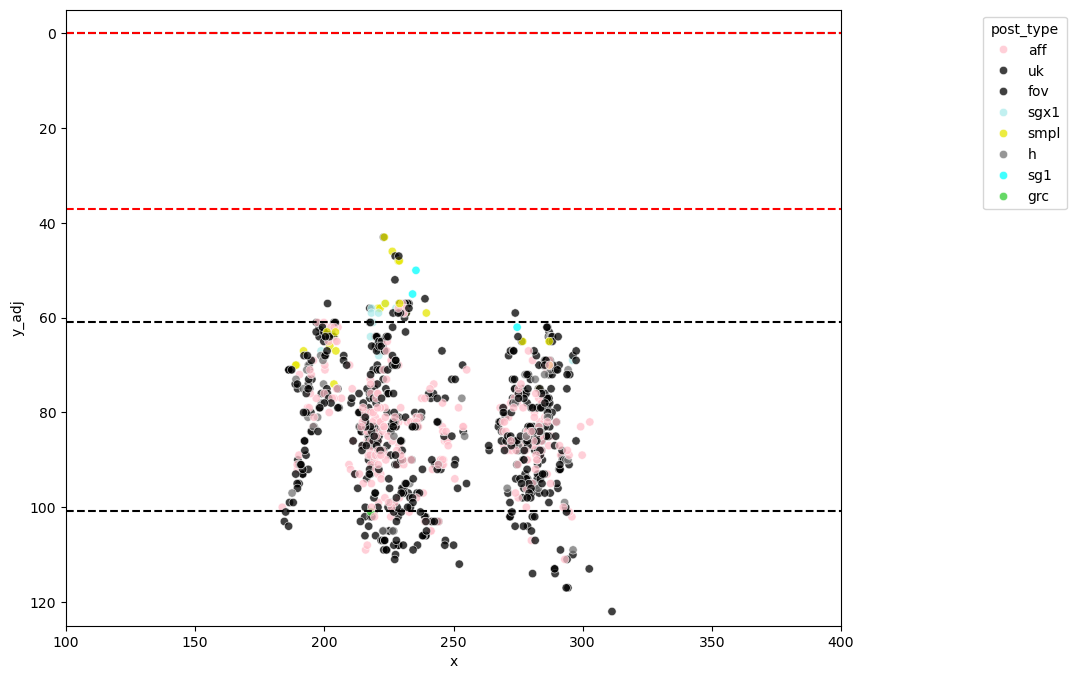

In [114]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_syn[df_syn['pre_type'].isin(['grc'])],x='x',y='y_adj',hue='post_type',palette=syn_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()